# Imports

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats        as ss
from boruta                import BorutaPy
from matplotlib            import pyplot       as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## Helper Functions

In [2]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs(( y - yhat ) / y))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index =[0])

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                      'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                      'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                      'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


# Function used to change the screen sizing of the notebook and enhance plots
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings();

Populating the interactive namespace from numpy and matplotlib


## Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# Data Description

In [4]:
df1 = df_raw.copy()

## Data Dictionary

| The data set used is from Kaggle (https://www.kaggle.com/c/rossmann-store-sales)



| Feature                                       |Description   
|:---------------------------|:---------------
| **Store**                         |  Unique Id for each store   | 
| **Sales**                       | Turnover for any given day  | 
| **Customers**                         |  Number of customers on a given day | 
| **Open**                         |  Indicator for whether the store was open: 0 = closed, 1 = open   | 
| **StateHoliday**                          | Indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = Public holiday, b = Easter holiday, c = Christmas, 0 = None| 
| **SchoolHoliday**                        | indicates if the (Store, Date) was affected by the closure of public schools| 
| **StoreType**                    | Differentiates between 4 different store models: a, b, c, d| 
| **Assortment**                       | Describes an assortment level: a = basic, b = extra, c = extended | 
| **CompetitionDistance**                    | Distance in meters to the nearest competitor store| 
| **CompetitionOpenSince[Month/Year]**                    | Gives the approximate year and month of the time the nearest competitor was opened| 
| **Promo**                    | Indicates whether a store is running a promo on that day| 
| **Promo2**                    | A continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating| 
| **Promo2Since[Year/Week]**                    | Describes the year and calendar week when the store started participating in Promo2| 
| **PromoInterval**                    | The consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store| 

## Rename Columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

#rename
df1.columns = cols_new

## Data Dimensions

In [7]:
print ('Number of Rows: {}'.format( df1.shape[0]))
print ('Number of Columns: {}'.format( df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime( df1['date'])

## Missing Values

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout Missing Values (NA)

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
#competition_distance - I will assume that the reason for being blank is because either there is no competitors or they are too far to be considered competitors
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 1000000.0 if math.isnan(x) else x)

#competition_open_since_month - I will assume that the reason for being blank is because either there is no competitors or the store was opened long before ours or someone did not add this data   
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
               
#promo_interval  
    # Map to convert number into name
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }
    # Fill with 0 so it does not compare with 'NaN'
df1['promo_interval'].fillna(0, inplace=True)
    # Extract the month of date and apply the month map to translate it
df1['month_map'] = df1['date'].dt.month.map(month_map)
    # Check if the month_map matches with the promo interval to understand if the promotion is happening (1) or not (0)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## Descriptive Statistics

In [15]:
# Split numerical and categorical features
num_attributes = df1.select_dtypes( include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

###  Numerical Attributes

In [16]:
#Central Tendency - mean, meadian

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concat

m= pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,1000000.0,999980.0,8013.285087,2330.0,51204.209542,18.891734,362.875468
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


###  Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

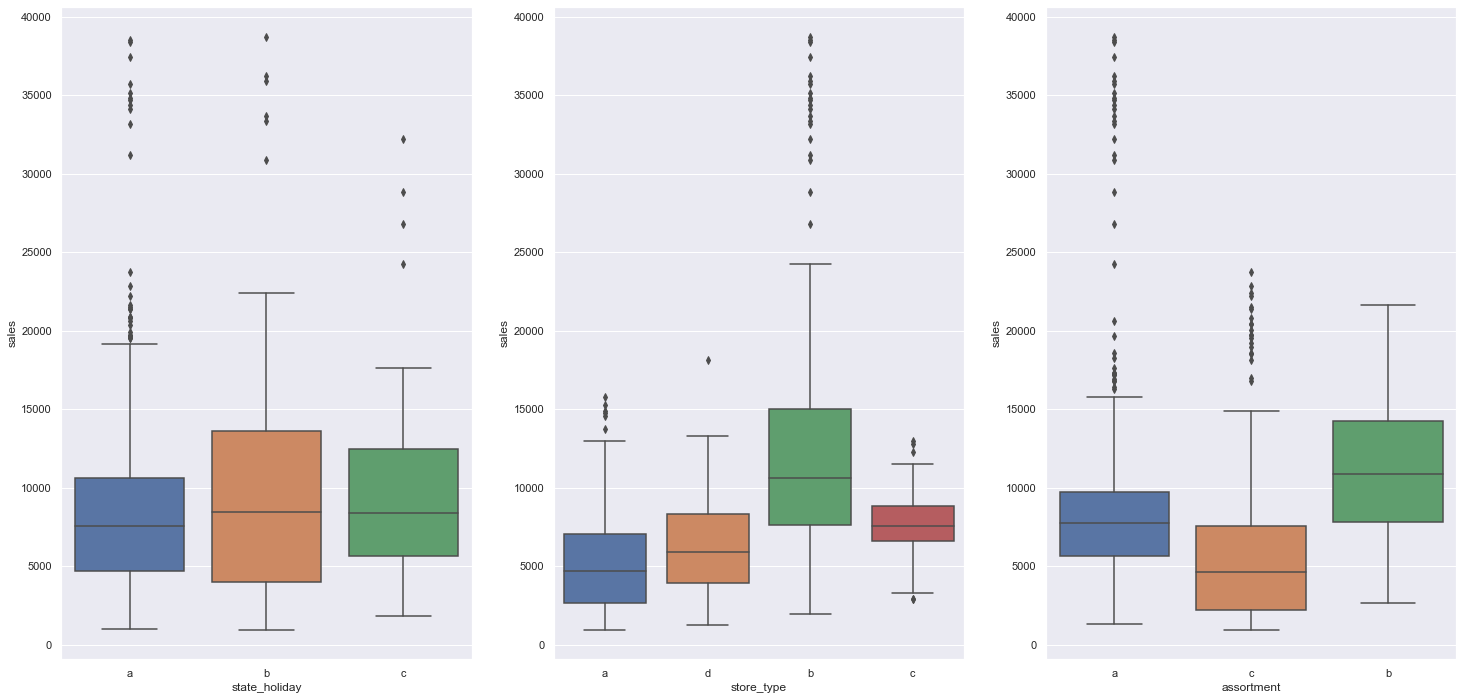

In [18]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot (1 , 3, 1)
sns.boxplot(x='state_holiday' , y= 'sales', data= aux1)

plt.subplot (1 , 3, 2)
sns.boxplot(x='store_type' , y= 'sales', data= aux1)

plt.subplot (1 , 3, 3)
sns.boxplot(x='assortment' , y= 'sales', data= aux1)

# Feature Engineering

In [19]:
df3 = df1.copy()

## MindMap

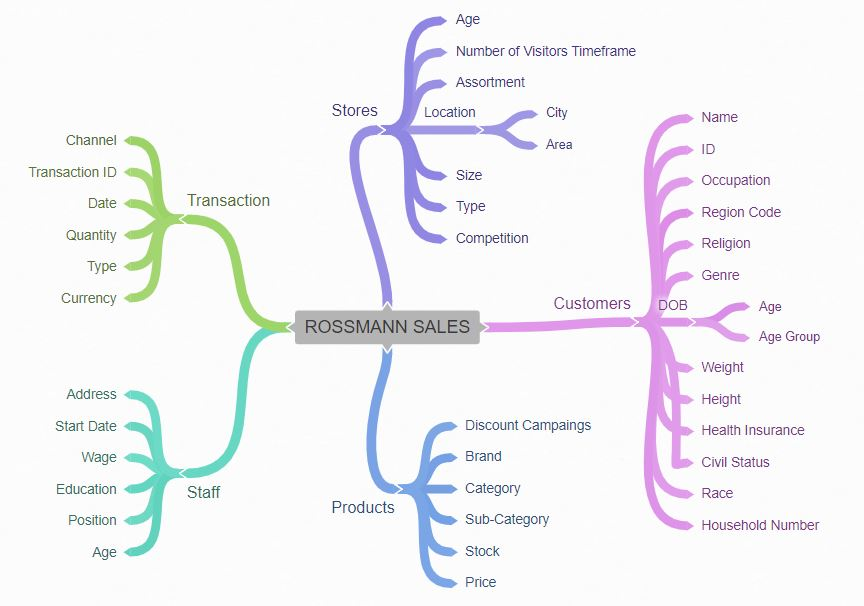

In [20]:
Image( 'img/mindmap.jpg')

## Hypothesis Formulation

### Customers

**1.** Older Customers should spend more

**2.** Customers with higher houselhold numbers should spend more

**3.** Customers with a BMI higher than 25 should spend more

**4.** Customers with a BMI lower than 18 should spend more

**5.** Married customers should spend more

**6.** Customers with health insurance should buy more

**7.** Customers with risky occupations should buy more


### Products

**1.** Hype brand products should sell more

**2.** Cheaper products should sell more

**3.** Products with often discount campaigns should sell more

**4.** Products with higher stock should sell more

### Staff

**1.** Staff with shorter commute to work time should sell more

**2.** Staff with higher wages should sell more

**3.** Older Staff should sell more 

**4.** Staff with more expirience should sell more

**5.** Staff with higher education should sell more

### Transactions

**1.** Holidays should have more transactions

**2.** Card Transactions should happen more often

**3.** Cash transactions should be of lower value

**4.** Fridays should have more transactions

**5.** Higher quantities should relate to more expensive transactions

### Stores

**1.** Stores placed on market for longer should sell more

**2.** Stores with closer competitions should sell less

**3.** Stores with longer discount campaigns should sell more 

**4.** Stores open on Christmas should sell more

**5.** Stores should sell more after the 10th of each month

**6.** "Extended" assortment stores should sell more

**7.** Smaller stores should sell less

**8.** Stores in urban areas should sell more

**9.** Stores with competitors opened for longer should sell more

**10.** Smaller stores should sell less

**11.** Stores with more promo days should sell more

**12.** Stores with consecutive promotions should more

**13.** Stores should sell more on weekends

## Final List of Hypothesis

**H1.** Stores placed on market for longer should sell more

**H2.** Stores with closer competitions should sell less

**H3.** Stores with longer discount campaigns should sell more 

**H4.** Stores open on Christmas should sell more

**H5.** Stores should sell more after the 10th of each month

**H6.** "Extended" assortment stores should sell more

**H7.** Stores with competitors opened for longer should sell more

**H8.** Stores with more promo days should sell more

**H9.** Stores with consecutive promotions should more

**H10.** Stores should sell more on weekends

## Feature Creation

In [21]:
# year
df3['year']= df3['date'].dt.year

#month
df3['month']= df3['date'].dt.month

#day
df3['day']= df3['date'].dt.day

#week of year
df3['week_of_year']= df3['date'].dt.weekofyear

#year week
df3['year_week']= df3['date'].dt.strftime( '%Y-%W' )

In [22]:
# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)
df3['competition_time_month'] = (( df3['date'] - df3['competition_since']  ) /30 ).apply( lambda x: x.days).astype(int)

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype( str ) + '-' + df3['promo2_since_week'].astype( str )
df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime ( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df3['promo_time_week'] = ( (df3['date'] - df3['promo_since'] ) / 7).apply( lambda x: x.days ).astype (int)

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else'extra' if x == 'b' else 'extended' )

# state holidays
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [23]:
df3['promo_time_day'] = df3['date'] - df3['promo_since']
df3['promo_time_day'] = df3.apply( lambda x: 1 if x['promo2'] == 0 else x['promo_time_day'], axis=1 )

In [24]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,promo_time_day
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,1
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,1957 days 00:00:00
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,1586 days 00:00:00
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,1
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,1


In [25]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [26]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Data Filtering

In [27]:
df4 = df3.copy()

In [28]:
df4.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,promo_time_day
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,1
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,1957 days 00:00:00
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,1586 days 00:00:00
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,1
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,1


## Rows Filtering

In [29]:
df4 = df4[(df4['open'] != 0 ) & (df4['sales'] > 0)]  

## Columns Selection

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop(cols_drop, axis = 1)

# Exploratory Data Analysis (EDA)

In [31]:
df5 = df4.copy()

## Univariate Analysis

### Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

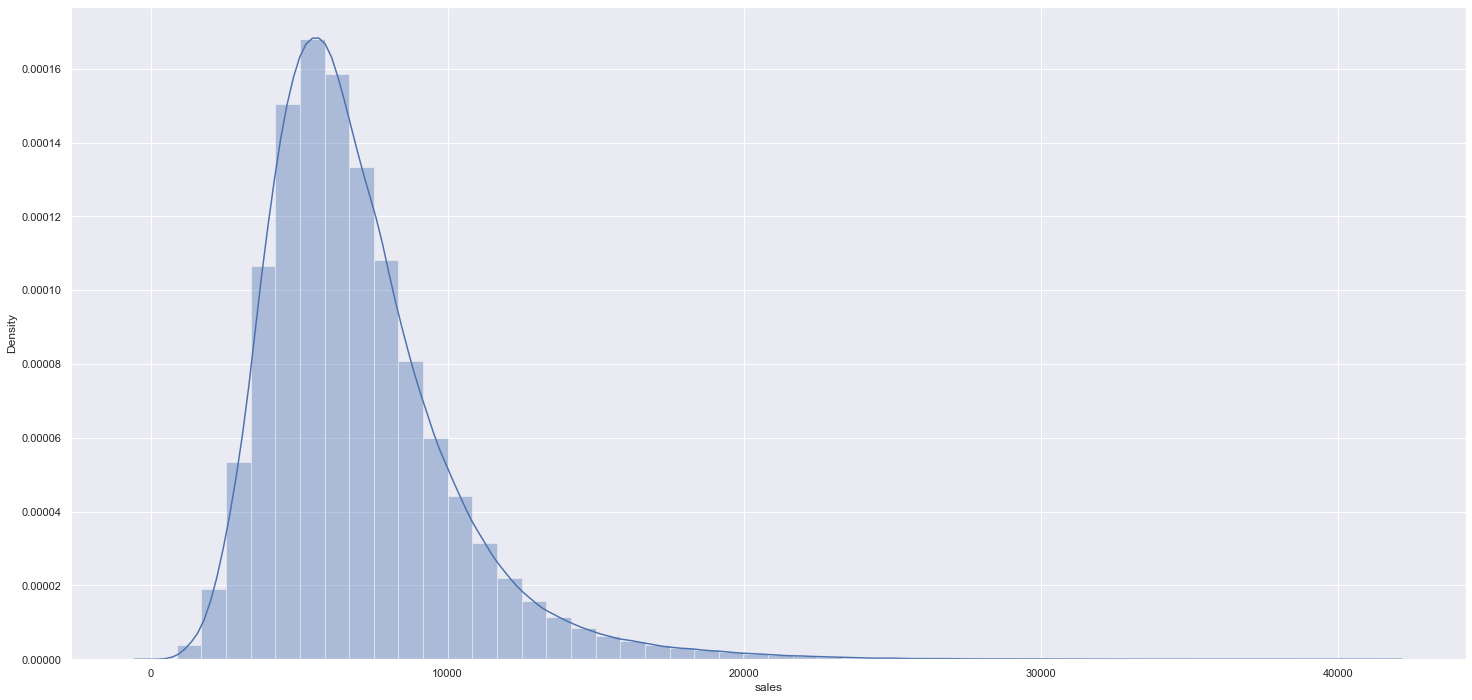

In [32]:
sns.distplot(df5['sales'])

### Numerical Variable

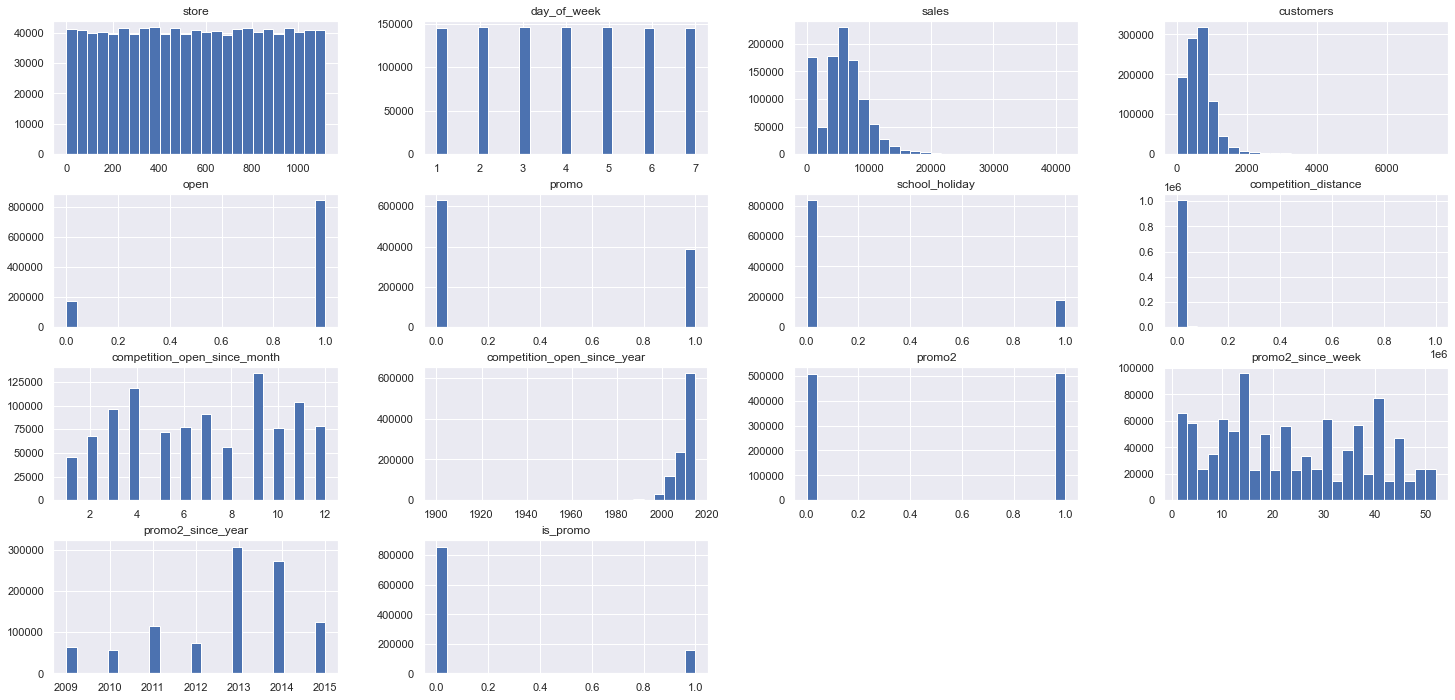

In [33]:
num_attributes.hist(bins=25);

### Categorical Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

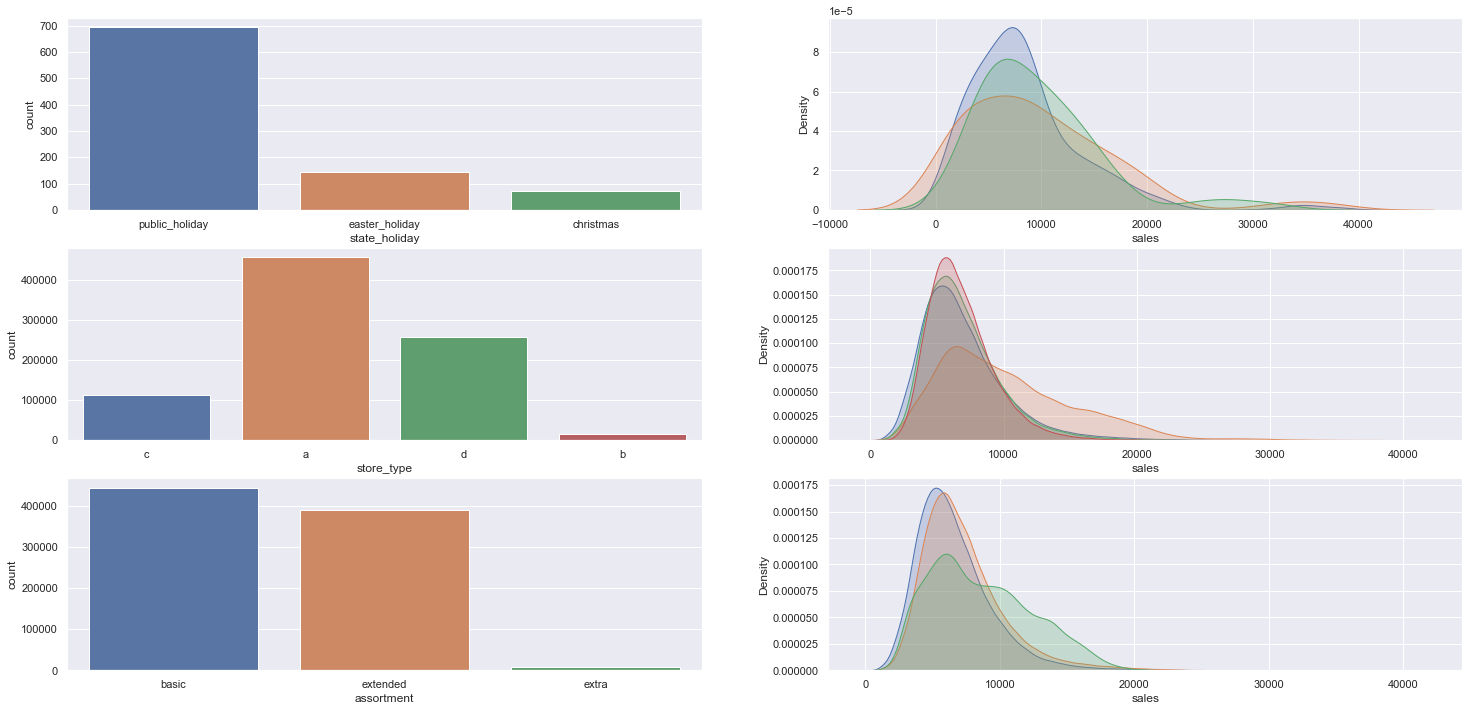

In [34]:
# state_holiday
plt.subplot(3,2,1)
a = df5[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df5['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df5['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True)

## Bivariate Analysis

### H1. Stores placed on market for longer should sell more

In [35]:
aux1 = df5[['year', 'sales']].groupby( 'year' ).mean().reset_index()
aux1.head()

,year,sales
0,2013,6814.775168
1,2014,7026.128505
2,2015,7088.235123


In [36]:
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()
aux1.head()

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


In [37]:
aux1 = df5[['year', 'store']].groupby( 'year' ).sum().reset_index()
aux1.head()

,year,store
0,2013,188565794
1,2014,173538628
2,2015,109391964


plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H2. Stores with closer competitions should sell less

In [ ]:
aux1 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Stores with longer discount campaigns should sell more 

In [ ]:
aux1 = df5[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H4. Stores open on Christmas should sell more

In [ ]:
aux = df5[df5['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### H5. Stores should sell more after the 10th of each month

In [ ]:
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );


### H6. "Extended" assortment stores should sell more

In [ ]:
aux1 = df5[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()

sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extended']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()


### H7. Stores with competitors opened for longer should sell more

In [ ]:
plt.subplot( 1, 3, 1 )
aux1 = df5[['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H8. Stores with more promo days should sell more

### H9. Stores with consecutive promotions should more

In [ ]:
df5[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index()

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### Resumo das Hipoteses

In [39]:
from tabulate import tabulate

In [40]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta


## Multivariable Analysis


### Numerical Variable

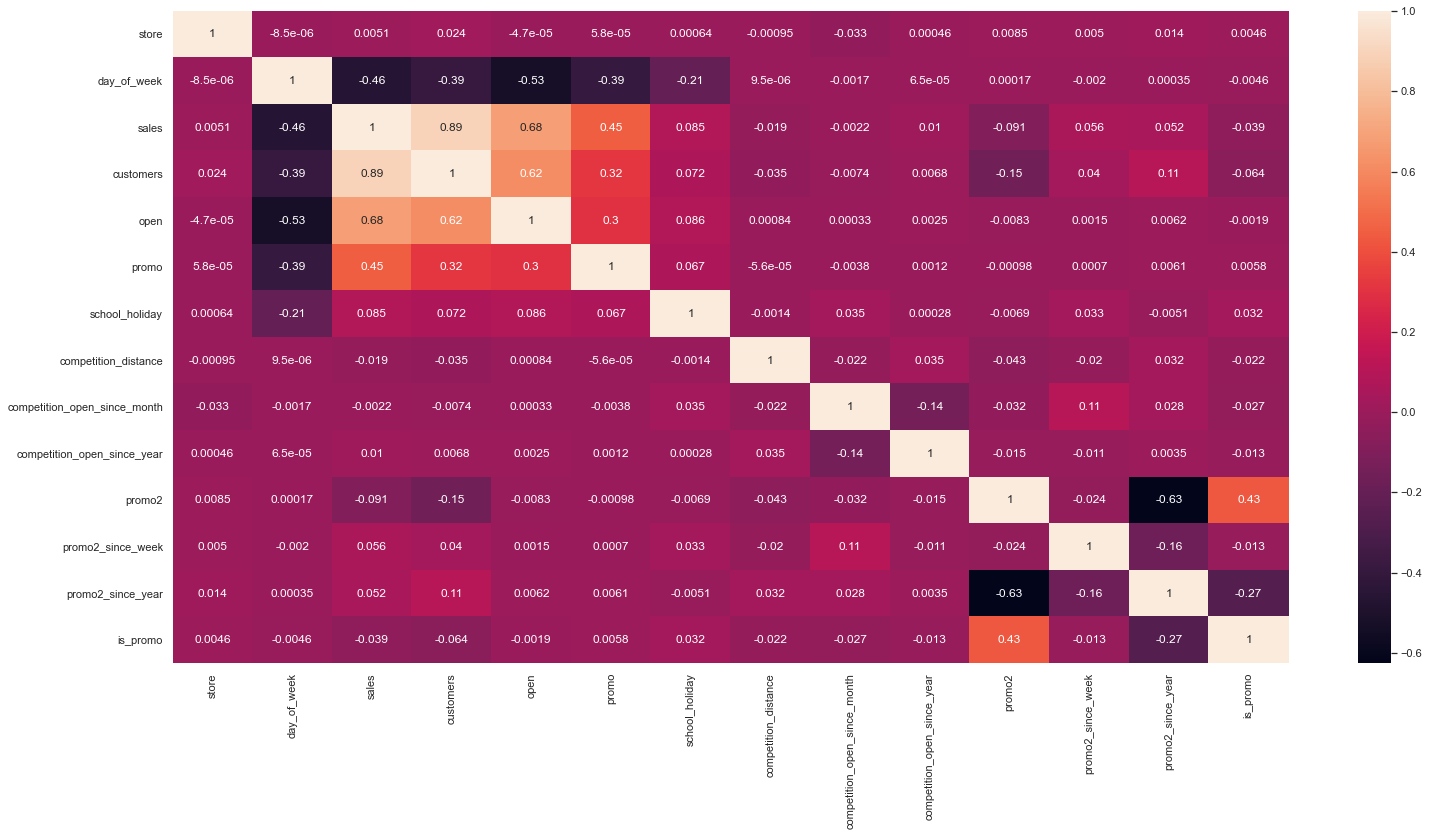

In [41]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### Categorical Attributes

<AxesSubplot:>

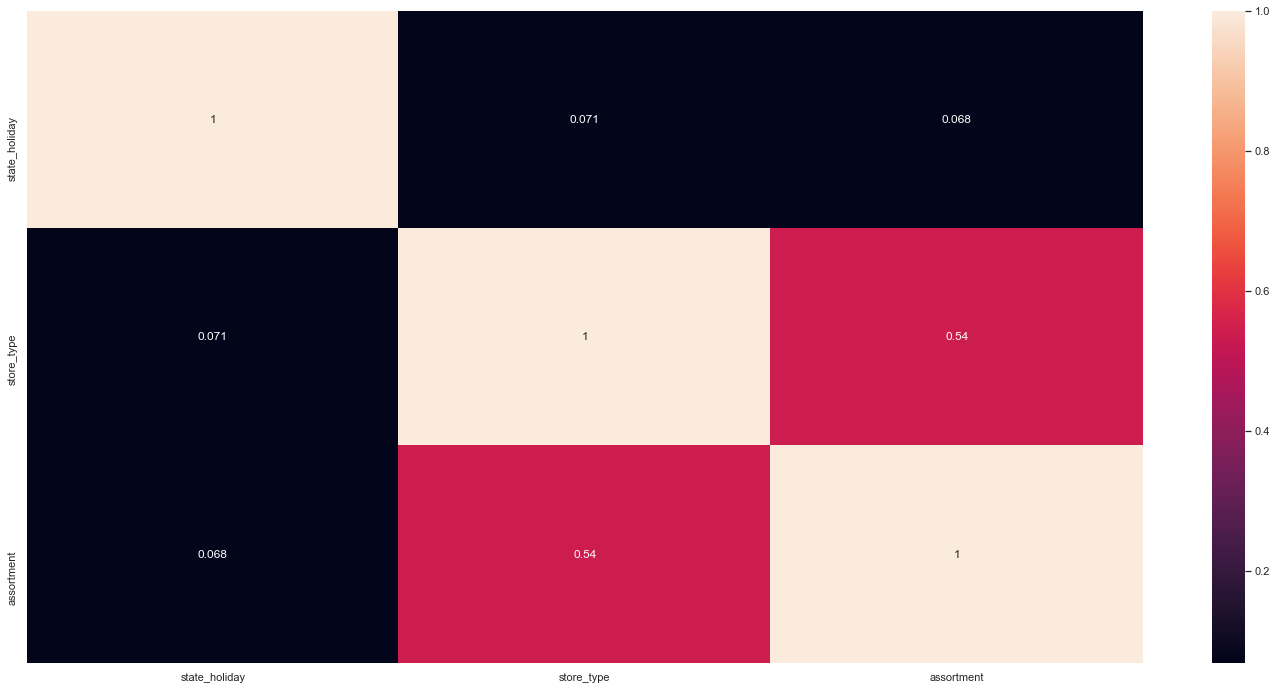

In [42]:
# only categorical data
a = df5.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# Data Preparation

In [43]:
df6 = df5.copy()

 ## Normalizacao

## Rescaling

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df6['competition_distance'] = rs.fit_transform( df6[['competition_distance']].values )
# competition time month
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values )
# promo time week
df6['promo_time_week'] = mms.fit_transform( df6[['promo_time_week']].values )
# promo time day
df6['promo_time_day'] = mms.fit_transform( df6[['promo_time_week']].values )
# year
df6['year'] = mms.fit_transform( df6[['year']].values )


## Transformacao

### Encoding

In [45]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies( df6, prefix=['state_holiday'], columns=['state_holiday'] )
# store_type - Label Encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform( df6['store_type'] )
# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df6['assortment'] = df6['assortment'].map( assortment_dict )

### Response Variable Transformation

In [46]:
df6['sales'] = np.log1p( df6['sales'] )

### Nature Transformation

In [47]:
# day of week
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )
# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )
# day
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
# week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )


# Feature Selection

In [48]:
df7 = df6.copy()

## Split dataframe into training and test dataset

In [49]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df7 = df7.drop( cols_drop, axis=1 )

In [50]:
df7['date'].max() - datetime.timedelta(days=30)

Timestamp('2015-07-01 00:00:00')

In [51]:
# training dataset
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [ ]:
## training and test dataset for Boruta

#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

## Best Features from Boruta

### Selected Features

In [62]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'promo_time_day',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

### Not Selected Features

In [63]:
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )
#cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## Manual Feature Selection

In [56]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'promo_time_day',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# Machine Learning Modelling 

In [57]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test [ cols_selected_boruta]

## Average Model

In [72]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## Linear Regression Model

### Single Performance

In [93]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1866.490146,0.294557,2669.09973


### Linear Regression Model - Cross Validation

In [135]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr , verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.47 +/- 302.54,0.3 +/- 0.01,2966.91 +/- 471.92


## Linear Regression Regularized Model - Lasso

### Single Performance

In [92]:
# model
lasso = Lasso(alpha = 0.01).fit(x_train, y_train)

# prediction
yhat_lasso = lasso.predict(x_test)

# performance
lasso_result = ml_error('Linear Regression Regularized Model - Lasso', np.expm1(y_test), np.expm1(yhat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized Model - Lasso,1889.529353,0.289747,2742.148844


### Linear Regression Regularized Model - Lasso - Cross Validation

In [136]:
lasso_result_cv = cross_validation( x_training, 5, 'Lasso', lasso , verbose=False )
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2118.1 +/- 341.62,0.29 +/- 0.01,3063.17 +/- 503.82


## Random Forest Regressor

### Single Performance

In [88]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,729.408862,0.108491,1071.586355


### Random Forest Regressor - Cross Validation

In [137]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,843.14 +/- 225.2,0.12 +/- 0.02,1262.41 +/- 331.57


## XGBoost Regressor

### Single Performance

In [89]:
# model
xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=100, 
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,
                        colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgbr = xgbr.predict(x_test)

# performance
xgbr_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgbr))
xgbr_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6682.282258,0.949284,7329.50984


### XGBoost Regressor - Cross Validation

In [ ]:
xgbr_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', xgbr )
xgbr_result_cv

## Comparing Models Preformance 

### Single Performance

In [138]:
models_results = pd.concat([baseline_result, lasso_result, lr_result, rf_result, xgbr_result])
models_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,729.408862,0.108491,1071.586355
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression Regularized Model - Lasso,1889.529353,0.289747,2742.148844
0,Linear Regression,2080.666614,0.283145,3033.994892
0,XGBoost Regressor,6682.282258,0.949284,7329.509840


### Real Performance - Cross Validation

In [ ]:
models_results_cv = pd.concat([lasso_result_cv, lr_result_cv, rf_result_cv, xgbr_result_cv])
models_results_cv.sort_values('RMSE')

# Hyperparameter Fine Tuning

## Random Search

In [157]:
param = {
    'n_estimators' : [15, 17, 25, 30, 25],
    'eta' : [0.01, 0.03],
    'max_depth' : [3, 5, 9],
    'subsample' : [0.1, 0.5, 0.7],
    'colsample_bytree' : [0.3, 0.7, 0.9],
    'min_child_weight' : [3, 8, 15]
        }
MAX_EVAL = 2

In [159]:
final_result = pd.DataFrame()

for i in range ( MAX_EVAL ):
    ## choose randomly values for parameters
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    # model
    model_xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=hp['n_estimators'], 
                        eta=hp['eta'],
                        max_depth=hp['max_depth'],
                        subsample=hp['subsample'],
                        colsample_bytree=hp['colsample_bytree'],
                        min_child_weight=hp['min_child_weight'])


    # performance
    model_xgbr_result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgbr, verbose=False)
    final_result = pd.concat([final_result, model_xgbr_result])
    
final_result

{'n_estimators': 30, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 17, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7412.41 +/- 128.26,1.0 +/- 0.0,8067.09 +/- 175.37
0,XGBoost Regressor,7380.24 +/- 128.21,0.99 +/- 0.0,8037.21 +/- 175.44


## Final Model

In [150]:
param_tuned = {
    'n_estimators' : 30,
    'eta' : 0.03,
    'max_depth' : 9,
    'subsample' : 0.1,
    'colsample_bytree' :0.7 ,
    'min_child_weight' :15
        }

In [155]:
# model
model_xgbr_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=param_tuned['n_estimators'], 
                        eta=param_tuned['eta'],
                        max_depth=param_tuned['max_depth'],
                        subsample=param_tuned['subsample'],
                        colsample_bytree=param_tuned['colsample_bytree'],
                        min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgbr_tuned = model_xgbr_tuned.predict(x_test)

# performance
xgbr_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgbr_tuned))
xgbr_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6763.253891,0.961668,7411.041207
